# Model structuur

Een belangrijke stap in tijdreeksanalyse is het bepalen van de modelstructuur van het tijdreeksmodel. Dit is het onderwerp van dit Notebook. We beperken ons hier tot het bepalen van het deterministische deel van het model. Het bepalen van het ruismodel is onderdeel van het notebook over modelkalibratie. In dit notebook wordt een overzicht gegeven van de verschillende opties die mogelijk zijn voor de modelstructuur.

### Inhoudsopgave

- [Basis model structuur](Basis-model-structuur)
- [Response functies](#Respons-functies)
- [Effect van neerslag en verdamping](#Effect-van-neerslag-en-verdamping)
- [Drempel niet-lineariteit](#Drempel-niet-lineariteit)
- [Rivieren en ontrekkingen](#Rivieren-en-ontrekkingen)
- [Veranderingen in het systeem](#Veranderingen-in-het-systeem)
- [Bepalen van invloeden](#Verklarende-variabelen)
- [Discussie](#Discussie)
- [Referenties](#Referenties)

## Algemeen stappenplan
Voor het kiezen van de gewenste modelstructuur is het belangrijk om vast te stellen wat het doel van het tijdreeksmodel is. Wanneer het doel van de modellering is vastgesteld, kunnen de volgende stappen worden doorlopen:

1. **Systeemanalyse**: bepaal mogelijke hydrologische variabelen,
2. **Modelbouw**: bepaal hoe deze variabelen worden omgezet in fluctuaties,
3. **Controle**: bepaal welke variabelen daadwerkelijk invloed hebben.

We gaan ervan uit dat de eerste stap al is uitgevoerd en bespreken de tweede en derde stap. Eerst wordt een overzicht gegeven van de bouwstenen die beschikbaar zijn om een model te bouwen. Daarna kijken we naar methoden om te bepalen welke bouwstenen nodig zijn in een model. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

from matplotlib.gridspec import GridSpec

ps.set_log_level("ERROR")
#ps.show_versions()

## Basis model structuur
Het tijdreeksmodel kan in zijn meest algemene vorm als volgt worden beschreven:

$$ h(t) = \sum_{m=0}^M h_m(t) + d + r(t) $$

Waar $h(t)$ de gemeten stijghoogte is, $h_m(t)$ is de bijdrage van invloed $m$, $d$ is het basisniveau van het model, en $r(t)$ zijn de modelresiduen. Het totaal aantal invloeden dat bijdraagt aan de stijghoogte fluctuaties is $M$. Dit notebook gaat voornamelijk over het bepalen van deze bijdragen, maar eerst volgt een korte uitleg over de constante $d$.

### Het basisniveau van het model
Vrijwel elk tijdreeksmodel bevat een constante (hier parameter $d$) waarmee het model op de juiste hoogte wordt gebracht. Hoewel verleidelijk, is het niet altijd juist een fysische betekenis aan deze constante toe te kennen. In de literatuur wordt soms verwezen naar de drainagebasis, het niveau waar het grondwater na verloop van tijd naar zou convergeren wanneer alle invloeden nul zijn. Of deze interpretatie juist is hangt echter af van het exacte model. Beter is daarom om eenvoudig naar $d$ te verwijzen als het basisniveau van het model.

Voor het bepalen van de waarde van de constante zijn verschillende methoden beschikbaar. De eerste 
optie is om na een simulatie het gemiddelde van de residuen te nemen als waarde voor $d$ (bv., [von Asmuth et al., 2002](#Referenties)). Dit betekend dat de parameter niet geschat hoeft te worden tijdens de kalibratie. Een andere optie is om $d$ mee te schatten als een parameter (bv., [Collenteur et al. 2019](#Referenties)). Dit heeft als voordeel dat er ook iets gezegd kan worden over de onzekerheid van deze parameter. Meer onderzoek is nodig om vast te stellen wat het effect is van het verschil tussen deze twee methoden om de uiteindelijke resultaten.

### Bijdragen
Stijghoogte fluctuaties kunnen door vele verschillende oorzaken ontstaan. Vaak hebben we een idee welke oorzaken belangrijk zijn, maar net zo vaak is dit juist het doel van de modellering. Wat het exacte effect van een bepaalde invloed kan afhangen van de gekozen vorm van de modellering, oftewel hoe de invloed vertaald wordt in een bijdrage aan de stijghoogte fluctuaties.

We kunnen twee typen invloeden onderscheiden: gemeten en niet gemeten invloeden. Voor gemeten invloeden zijn verklarende tijdreeksen beschikbaar om de bijdrage van een invloed aan de stijghoogte fluctuaties te bepalen. Dit zijn bijvoorbeeld: neerslag, potentiele verdamping, ontrekkingen, oppervlakte waterstanden en luchtdruk metingen. Dit type invloeden kan worden vertaald in een bijdrage met behulp van een impuls respons functie.

Voor niet gemeten invloeden zijn (vaak)geen verklarende tijdreeksen beschikbaar en het effect van dit type invloeden is lastiger vast te stellen. Voorbeelden zijn veranderend landgebruik, ingreep in de waterhuishouding (bv. opzet Ijsselmeer). Dit type bijdrage kan worden meegenomen door een trend mee te nemen in de modellering. De op te geven informatie is in dit geval een periode of tijdstap wanneer een verandering heeft plaats gevonden.

## Respons functies
De vertaling van een verklarende tijdreeks naar een bijdrage aan de stijghoogte fluctuaties kan worden gedaan met behulp van een impuls respons functies. De impuls respons functie beschrijft in dit geval hoe de stijghoogte reageert op een impuls van de verklarende tijdreeks. Er zijn tal van respons functies die kunnen worden gekozen om een verklarende tijdreeks om te zetten in een bijdrage aan de stijghoogte fluctuaties. De keuze voor een bepaalde respons functie kan bijvoorbeeld afhangen van het type verklarende reeks (bv. neerslag of een rivier), maar ook van het systeem (bv. een dikke of dunne overzadigde zone).

Vaak wordt een 4-parameter gamma functie of een vereenvoudigde vorm daarvan gebruik als impuls respons functie. Afhankelijk van het systeem kunnen bepaalde parameters worden vastgezet, wat het aantal te schatten parameters verlaagt. In de volgende figuur worden drie impuls respons functie getoond die elk een vereenvoudigde vorm van de 4-parameter gamma functie zijn.

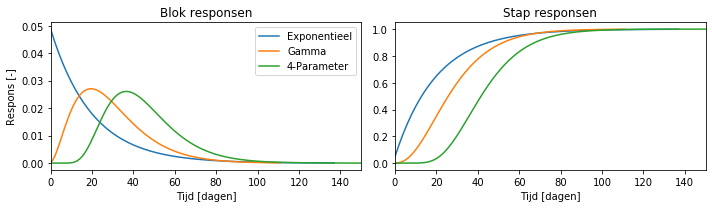

In [2]:
# Voorbeeld van Gamma respons functie waar n=1, en hetzelfde model met een exponentiele functie

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

rfuncs = [ps.Exponential, ps.Gamma, ps.FourParam]
params = [[1, 20], [1, 3, 10], [1, 2, 10, 10]]

for rfunc, param in zip(rfuncs, params):
    rfunc = rfunc(up=True)
    p = rfunc.get_init_parameters("p")
    ax1.plot(rfunc.block(param))
    ax2.plot(rfunc.step(param))
ax1.set_xlim(0, 150)
ax1.set_title("Blok responsen")
ax2.set_title("Stap responsen")
ax1.set_xlabel("Tijd [dagen]")
ax2.set_xlabel("Tijd [dagen]")
ax1.set_ylabel("Respons [-]")
ax1.legend(["Exponentieel", "Gamma", "4-Parameter"]);
plt.tight_layout()

De exponentiele respons heeft 2 parameters, de Gamma heeft 3 parameters, en de 4-parameter gamma functie heeft 4 parameters. Het kan echter goed voorkomen dat de parameters van de 4-parameter functie na kalibratie eigenlijk een Gamma of zelfs exponentiele functie simuleren. Het is dan mogelijk parameters vast te zetten en op die manier het aantal te schatten parameters te reduceren. Het dient over het algemeen aanbeveling verschillende respons functies te testen. Per software pakket dient te worden bepaalt welke respons functies beschikbaar zijn.

- Hantush, fysische interpretatie hangt af van bodemopbouw
- Vervang 4-param met Hantush

## Effect van neerslag en verdamping

Vrijwel alle grondwaterstanden in Nederland worden in meer of mindere mate beinvloed door neerslag en verdamping. Deze twee verklarende tijdsreeksen worden daarom bijna altijd in een tijdreeksmodel opgenomen. De manier waarop deze tijdreeksen worden meegenomen in het model kunnen sterk verschillen. We kunnen grofweg drie methoden onderscheiden: 

- Neerslag en verdamping als aparte invloeden
- Netto neerslagoverschot ($N = P-fE$) en 1 respons functie 
- Niet-lineaire grondwateraanvulling en 1 respons functie

### Voorbeeld data
In de volgende drie secties wordt een model gemaakt volgens deze drie methoden. De stijghoogte tijdreeks die in dit voorbeeld is gebruikt is gemeten in een monitorings put B32C0639 (filter 1) nabij de Bilt. Neerslag en potentiele Makkink verdamping is beschikbaar van het KNMI meteorologisch meetstation de Bilt.

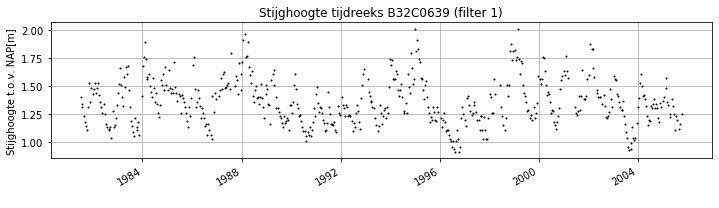

In [3]:
head = pd.read_csv("data/B32C0639001.csv",  parse_dates=['date'], index_col='date', squeeze=True)

fig, ax1 = plt.subplots(1, 1, figsize=(10,3))
head.plot(ax=ax1, marker=".", color="k", linestyle=" ", markersize=2)
ax1.grid()
ax1.set_title("Stijghoogte tijdreeks B32C0639 (filter 1)")
ax1.set_ylabel("Stijghoogte t.o.v. NAP[m]")
ax1.set_xlabel(" ");
plt.tight_layout()

### Neerslag en verdamping als aparte invloeden
Bij deze methode worden de twee tijdreeksen van neerslag en verdamping onafhankelijk van elkaar meegenomen in het tijdreeksmodel. Door middel van twee aparte (en wederom onafhankelijke) responsfuncties worden de tijdreeksen vertaald in bijdragen aan de stijghoogte fluctuaties. Hieronder is een voorbeeld gegeven van het resultaat van een dergelijk model voor de voorbeeld data.

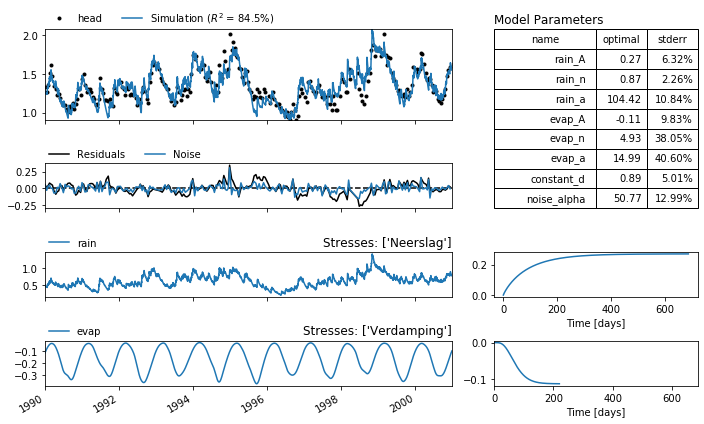

In [4]:
# Voorbeeld van neerslag en verdamping met aparte respons functies
head = pd.read_csv("data/B32C0639001.csv",  parse_dates=['date'],
                   index_col='date', squeeze=True)
evap = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series * 1e3
rain.name = "Neerslag"
evap.name = "Verdamping"

tmin = "1990"
tmax = "2001"

# Create the basic Pastas model
ml1 = ps.Model(head, name="2 responsen")

# Add a recharge model
rm1 = ps.StressModel(rain, rfunc=ps.Gamma, name="rain", up=True)
rm2 = ps.StressModel(evap, rfunc=ps.Gamma, name="evap", up=False)

ml1.add_stressmodel([rm1, rm2])

# Solve the model
ml1.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml1.plots.results(figsize=(10, 6));

De onderste twee linker subplots tonen de geschatte invloed van de neerslag en de verdamping. De neerslag heeft een positief (stijgend) effect op de stijghoogte en de verdamping een dalend effect. Voor beide respons functies (zie de onderste twee rechter subplots) moeten de parameters worden geschat. Het totaal aantal geschatte parameters van dit model is 8.

### Lineair neerslagoverschot
Een veelgemaakte aanname is dat de respons van de stijghoogte op neerslag en verdamping vergelijkbaar is, maar in de tegenovergestelde richting. Hoewel uit bijvoorbeeld bovenstaande figuur blijkt dit niet altijd het geval is, is in de praktijk gebleken dat deze aanname toch vaak goede modellen oplevert. Onder deze aanname is het mogelijk eerst het neerslagoverschot te berekenen ($N = P - E$) en deze flux te vertalen in een bijdrage aan de stijghoogtefluctuaties met een enkele respons functie.

Omdat vaak gewerkt wordt met de potentiele verdamping (bijvoorbeeld Makkink of Penman-Monteith) wordt een verdampingsfactor $f$ gebruikt. Het neerslag overschot wordt dan berekend als : $N = P - f *E$, waar $f$ een kalibratie parameter is. Een belangrijk voordeel van dit model ten op zichte van het voorgaande model is het kleinere aantal parameters dat geschat moet worden.

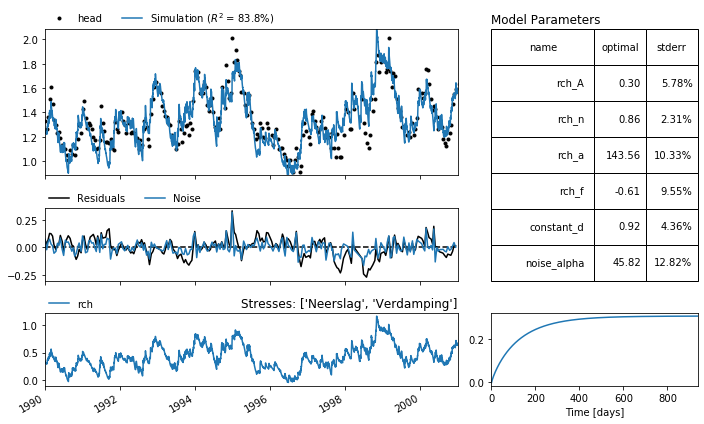

In [5]:
### Voorbeeld van netto neerslagoverschot (N = P-fE) en gamma respons functie

# Create the basic Pastas model
ml2 = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml2.add_stressmodel(rm)

# Solve the model
ml2.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml2.plots.results(figsize=(10, 6));

In de figuur hierboven is het resultaat van dit model voor de voorbeeld data getoond. De geschatte verdampingsfactor is $f=-0.61$. Terwijl dit model twee kalibratie parameters minder heeft is de model fit vrijwel gelijk aan het eerste model.

### Niet-lineaire grondwateraanvulling
Bij de derde methode wordt een niet-lineair model gebruikt om grondwateraanvulling te berekenen, die vervolgens ook geconvolueerd wordt met een respons functie. Verschillende niet-lineaire modellen zijn beschikbaar, zie bijvoorbeeld [Berendrecht et al. (2005)](#Referenties), [Peterson en Western (2014)](#Referenties) en [Collenteur et al. (2020)](#Referenties). Al deze modellen hebben de vorm van een bakje, waar neerslag en verdamping in en uit gaat aan de bovenkant, en grondwateraanvulling uitkomt aan de onderkant. Een voorbeeld van een dergelijk model is hieronder weergegeven. Dit model bevat ook een bakje voor interceptie.

![title](data/conceptual_model.pdf)

Een voordeel van niet-lineaire modellen is dat er rekening wordt gehouden met processen in de onverzadigde zone, waardoor de stijghoogte niet meer lineair reageert op neerslag en verdamping. Dit gebeurt bijvoorbeeld wanneer de verdamping wordt beperkt door de de beschikbare bodemvocht ten tijd van droogte, of door de berging van neerslag in de onverzadigde zone. 

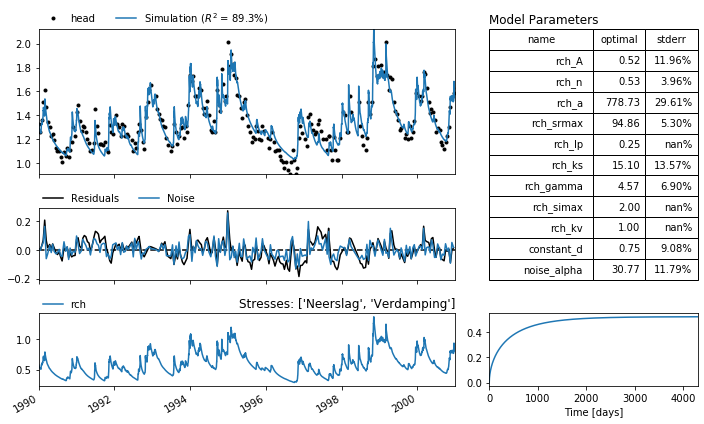

In [6]:
# Voorbeeld van Niet-lineaire grondwateraanvulling en exponentiele response functie
ml3 = ps.Model(head, name="niet-lineair")

# Add a recharge model
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml3.add_stressmodel(rm)

# Solve the model
ml3.set_parameter("constant_d", initial=head.min())  # Start below the lowest head
ml3.solve(noise=True, tmin=tmin, tmax=tmax, initial=True, report=False)
ml3.plots.results(figsize=(10, 6));

Mogelijke nadelen van niet-lineaire modellen kunnen een groter aantal vrije parameters zijn of de rekentijd van het model. Het is echter vaak mogelijk een aantal parameters vast te zetten en een response functie te gebruiken met minder parameters, waardoor het aantal vrije parameters sterk is te reduceren. Door ontwikkelingen in de software is de rekentijd eigenlijk geen argument meer om niet-lineaire modellen niet te gebruiken.

### Welk model is het beste?
We hebben nu drie modellen voor een stijghoogte reeks die goed verklaart kan worden door neerslag en verdamping. Het model met twee aparte responsen heeft een $R^2=0.85$, het lineaire model $R^2=0.84$ en het niet-lineaire model $R^2=0.89$. De modellen ontlopen elkaar dus eigenlijk niet zo veel wat betreft deze fit statistiek. Het is aan de modelleur om nu een van deze modellen te kiezen of deze allemaal te gebruiken.

Een veelgebruikte methode om het "beste" model te selecteren is door de fit van de modellen buiten de kalibratieperiode te berekenen. In de figuur hieronder is met elk model de stijghoogte in voor een periode na de kalibratieperiode gesimuleerd (2001-2006). In de legenda is de determinatie coefficient weergegeven. Nu is het model met de twee responsen het beste model volgens de $R^2$ statistiek ($R^2=0.88$), en hebben het lineaire en niet-lineaire model een slechtere fit ($R^2=0.86$).

De model fits zijn in dit voorbeeld zeer vergelijkbaar. De modelleur kan er in dit geval bijvoorbeeld voor kiezen het model met het laagste aantal parameters te kiezen. Dit aantal is het laagste voor het lineaire model ($n=6$), en de andere twee modellen hebben beide meer parameters hebben (beide $n=8$).

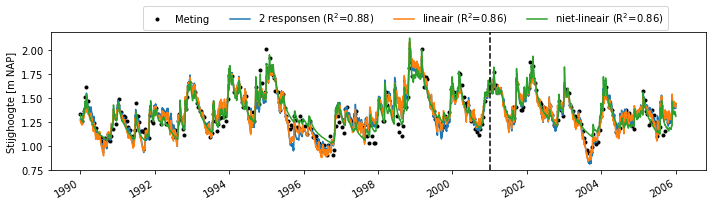

In [7]:
ax = ml1.oseries.series[tmin:].plot(marker=".", linestyle=" ", color="k", figsize=(10,3))

labels = ["Meting"]
for ml in [ml1, ml2, ml3]:
    ml.simulate(tmax="2006").plot()
    labels.append("{} (R$^2$={})".format(ml.name, ml.stats.rsq(tmin=tmax, tmax="2006").round(2)))
ax.axvline(pd.Timestamp(tmax), color="k", linestyle="--")
plt.legend(labels, ncol=4, bbox_to_anchor=(0.95, 1.22))
plt.ylabel("Stijghoogte [m NAP]");
plt.tight_layout()

### Dikkere onverzadigde zone
In het voorgaande voorbeeld bleek uiteindelijk dat een linear model genoeg is om de grondwaterstand te modelleren. De grondwaterstand in dit voorbeeld is dichtbij het maaiveld, wat betekend dat de wortelzone mogelijk water opneemt uit het grondwater. Het lineaire model kan een negatieve flux simuleren, het niet-lineaire model in het voorbeeld hierboven niet. [Peterson et al (2014)](#Referenties) heeft hier wel een oplossing voor uitgewerkt voor diepe grondwaterstanden en wortelsystemen in Austrialie.

Wanneer de wortelzone niet tot de grondwaterspiegel rijkt en er dus geen verdamping van grondwater plaatsvindt kan een niet-lineair model duidelijk verschil maken.

HIER MOET EEN BETER VOORBEELD WORDEN GEVONDEN!!

In [8]:
head = ps.read_dino("data/B27D0140001_1.csv")
prec = ps.read_knmi("data/neerslaggeg_OLDEBROEK_336.txt", variables="RD").series * 1e3
prec.index = prec.index.round("D")
prec = prec.asfreq("D")
evap = ps.read_knmi("data/etmgeg_275.txt", variables="EV24").series.asfreq("D") * 1e3

ml = ps.Model(head, name="B27D0140_1")
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)

# Solve the model
#ml.set_parameter("constant_d", initial=head.series.min())  # Start below the lowest head
ml.set_parameter("rch_kv", vary=True)

ml.solve(noise=False, tmin="2000", tmax="2018", report=False)
r2_nl = round(ml.stats.rsq(), 2)
# ml.set_parameter("rch_srmax", vary=False)
# ml.solve(noise=True, initial=False,  tmin="2005", tmax="2015", report=False)
sim = ml.simulate()

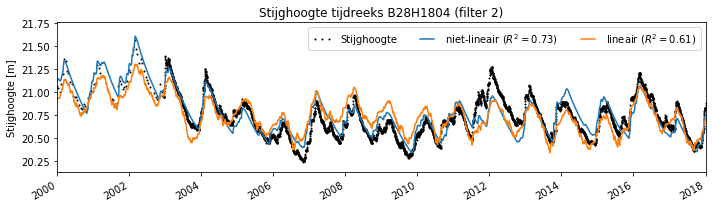

In [9]:
ml = ps.Model(head, name="B27D0140_1")
rch = ps.rch.Linear()
rm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)

# Solve the model
#ml.set_parameter("constant_d", initial=head.series.min())  # Start below the lowest head
ml.solve(noise=False, tmin="2000", tmax="2018", report=False)
r2_l = round(ml.stats.rsq(), 2)
# Plot de resultaten
fig, ax = plt.subplots(1, 1, figsize=(10,3))
head.plot(ax=ax, marker=".", color="k", linestyle=" ", markersize=2)

ax.plot(sim)
ml.simulate().plot(ax=ax)
ax.set_xlim(["2000", "2018"])
#ax.set_ylim(18.2, 20.0)
ax.set_ylabel("Stijghoogte [m]")
ax.set_title("Stijghoogte tijdreeks B28H1804 (filter 2)")
ax.legend(["Stijghoogte",  f"niet-lineair ($R^2=${r2_nl})", f"lineair ($R^2=${r2_l})"], ncol=4, loc=1, numpoints=3);
plt.tight_layout()

## Drempel niet-lineariteit
Een veelvoorkomend fenomeen in (lager gelegen) delen van Nederland is drempel niet-lineariteit (zie bv. [Berendrecht et al. (2004) en von Asmuth et al. 2012)](#Referenties)). Daarbij reageert een grondwatersysteem anders op een impuls (bv. neerslag) nadat een bepaalde grenswaarde in de stijghoogte is overschreden. [Knotters et al. (1999)](#Referenties) hebben hiervoor een model ontwikkeld, het zogeheten TARSO model, waarbij de respons op neerslagoverschot afhangt van de stijghoogte boven of onder een bepaalde drempelwaarde. Wanneer de stijghoogte boven deze drempelwaarde komt, kan het bijvoorbeeld zo zijn dat afstroming naar het oppervlaktewater plaats vind (bv. een sloot die anders droog staat). Of er sprake is van drempel niet-lineariteit kan worden vastgesteld door:

1. een visuele inspectie of de stijghoogte tijdreeks afgevlakt is, 
3. het plotten van een histogram van de stijghoogte metingen, of
2. het testen van verschillende modelstructuren.

---

Als voorbeeld kijken we naar een stijghoogte reeks B28H1804 (filter 2) in de buurt van Weerselo. De gegevens in Dinoloket laten zien dat het maaiveeld bij ditpunt of 19.44 meter t.o.v. NAP ligt. In onderstaande figuur is de stijghoogte tijdreeks en een histogram van de reeks afgebeeld voor een visuele inspectie van de tijdreeks (stap 1 & 2). 

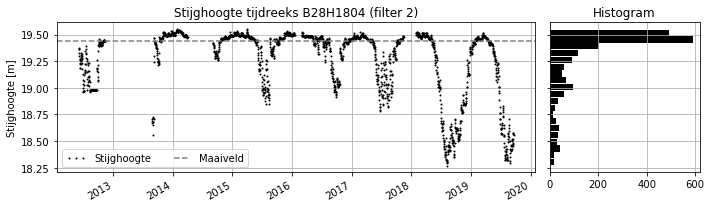

In [10]:
head = ps.read_dino("data/B28H1804001_1.csv").series

fig = plt.figure(figsize=(10,3))

gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1], sharey=ax1)

head.plot(ax=ax1, marker=".", color="k", linestyle=" ", markersize=2)
ax1.grid()
ax2.grid()
plt.hist(head, orientation="horizontal", bins=20, color="k", rwidth=0.9)
ax1.axhline(19.44, linestyle="--", color="gray")
ax1.set_title("Stijghoogte tijdreeks B28H1804 (filter 2)")
ax1.set_ylabel("Stijghoogte [m]")
ax2.set_title("Histogram");
ax1.legend(["Stijghoogte", "Maaiveld"], ncol=2, numpoints=3)
plt.tight_layout()

Uit bovenstaande plots is af te leiden dat er mogelijk sprake is van drempel niet-lineariteit. De stijghoogte reeks is afgevlakt rond 19.50-19.75 en de histogram laat een duidelijke scheve verdeling zien. Op basis van de visuele inspectie kunnen we bijvoorbeeld besluiten om twee modellen te testen: de eerste met een simpel neerslag overschot ($N = P - fE$) en een tweede met drempel niet-lineariteit (hier, het TARSO model). Vervolgens kan dan worden beoordeeld welk model "beter" is en wordt gebruikt voor verdere analyse.

Onderstaande figuur geeft de resultaten van de twee modellen weer. Het lineaire model geeft een structurele overschatting van de hoge grondwaterstanden, waar het drempel niet-lineaire model netjes de gemeten grondwaterstand volgt.

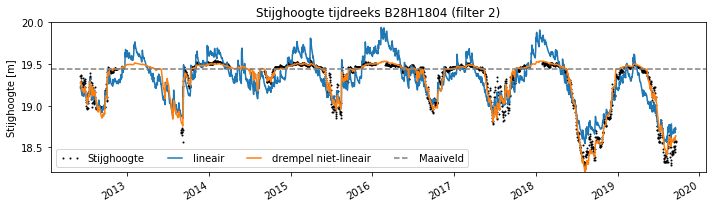

In [11]:
prec = pd.read_csv("data/RD Weerselo.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3
evap = pd.read_csv("data/EV24 Twenthe.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3

ml = ps.Model(head, name="B28H1804_2")
rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma, recharge=ps.rch.Linear())
ml.add_stressmodel(rm)
# the model is already solved, but we solve it again to be certain
ml.solve(noise=False, report=False)
sim = ml.simulate()

# Plot van lineair model versus een drempel niet-lineair model.
sm = ml.stressmodels['recharge']
prec = sm.stress[0]
evap = sm.stress[1]

# delete all the stressmodels, the constant and the transform
ml.del_stressmodel('recharge')
ml.del_constant()

# then add a TarsoModel
sm = ps.TarsoModel(prec, evap, ml.oseries)
ml.add_stressmodel(sm)

# and solve again
ml.solve(noise=False, report=False)

# Plot de resultaten
fig, ax = plt.subplots(1, 1, figsize=(10,3))
head.plot(ax=ax, marker=".", color="k", linestyle=" ", markersize=2)

ax.plot(sim)
ml.simulate().plot(ax=ax)
ax.set_ylim(18.2, 20.0)
ax.set_ylabel("Stijghoogte [m]")
ax.set_title("Stijghoogte tijdreeks B28H1804 (filter 2)")
ax.axhline(19.44, linestyle="--", color="gray")
ax.legend(["Stijghoogte",  "lineair", "drempel niet-lineair", "Maaiveld"], ncol=4, loc=3, numpoints=3);
plt.tight_layout()

## Andere verklarende variabelen
Tot op dit punt hebben we gekeken naar stijghoogte tijdreeksen die zich goed laten verklaren door neerslag en verdamping. In veel gevallen zijn echter andere verklarende tijdreeksen nodig om de stijghoogte goed te kunnen modelleren. Twee invloeden die vaak belangrijk zijn, zijn oppervlaktewaterpeilen en grondwaterontrekkingen. In de volgende twee secties wordt beschreven hoe de effecten van deze invloeden kunnen worden gemodelleerd.

### Oppervlaktepeil als verklarende tijdreeks
In grote delen van Nederland worden de stijghoogten beinvloed door oppervlaktewaterpeilen. Dit kunnen grote rivieren en meren als de Rijn en het Ijsselmeer zijn, maar ook kleinere vennen en slootjes in de polder. Het is niet ongebruikelijk dat het nodig is een tijdreeks van een nabijgelegen oppervlaktewaterpeil toe te voegen aan het tijdreeksmodel om de stijghoogte goed te kunnen modeleren. 

We kunnen dit wederom doen door de tijdreeks van het gemeten oppervlaktewaterpeil te vertalen naar een bijdrage aan de stijghoogtefluctuaties met behulp van een respons functie. De repons functie beschrijft dan de reactie van de stijghoogte op fluctuaties in het oppervlaktewaterpeil. Het is aan te bevelen om deze tijdreeks eerst te normaliseren door bijvoorbeeld het gemiddelde om de mediaan er van af te trekken. We zijn immers enkel geintereseerd in de veranderingen in het oppervlaktewaterpeil en niet in het absolute niveau. Meer informatie over normaliseren van tijdreeksen is te vinden in het hoofdstuk over [Voorbewerking](#Voorbewerking).

---

Als voorbeeld modeleren we de stijghoogte tijdreeks gemeten in peilbuis 40CP0393 (filter 4). Eerst maken we een model met enkel neerslag en verdamping als verklarende variabelen. Deze worden vertaald in stijghoogte fluctuaties met een lineair neerslagoverschot model en een Gamma respons functie. Dit model levert de volgende simulatie van de stijghoogte op.

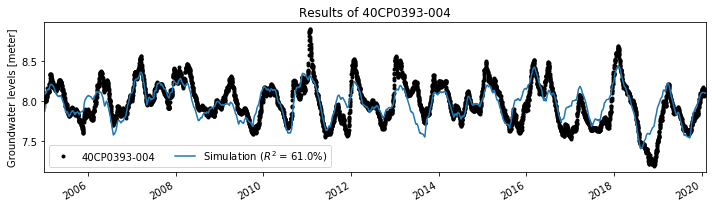

In [12]:
# Code met dit model hier
head = pd.read_csv("data/40CP0393-004.csv", index_col=0, parse_dates=True, squeeze=True).resample("D").mean().dropna()
prec = pd.read_csv("data/RD_Nijmegen.csv", index_col=0, parse_dates=True) * 1e3
evap = pd.read_csv("data/EV24_Deelen.csv", index_col=0, parse_dates=True) * 1e3

ml = ps.Model(head, name="40CP0393-004")
sm = ps.RechargeModel(prec, evap, name="rch", recharge=ps.rch.Linear(), rfunc=ps.Gamma)
ml.add_stressmodel(sm)

ml.solve(tmin="2005", report=False)
ml.plot(figsize=(10, 3));
plt.tight_layout()

Uit bovenstaande figuur blijkt duidelijk dat het neerslagoverschot niet genoeg is om de stijghoogte fluctuaties te verklaren. Uit de hydrologische systeem analyse van het studiegebied blijkt dat de peilbuis dichtbij een oppervlaktewaterlichaam ligt. We kunnen dan de rivierwaterstand als verklarende tijdreeks aan het model toevoegen en kijken of dit de simulatie van de stijghoogte verbetert. We kiezen hier voor de algemene Gamma respons functie met drie parameters om het oppervlaktewaterpeil te vertalen in stijghoogtefluctuaties.

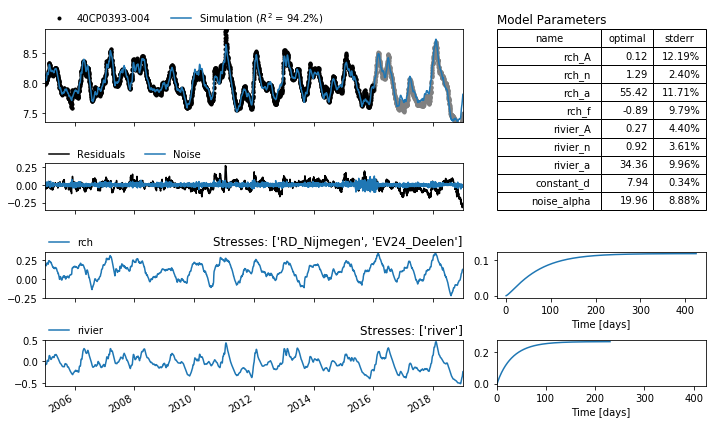

In [13]:
rivier = pd.read_csv("data/40CP0393-rivier.csv", index_col=0, parse_dates=True, squeeze=True)
sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Gamma)
ml.add_stressmodel(sm2)

ml.solve(tmin="2005", tmax="2016", report=False)
ml.plots.results(figsize=(10, 6), tmax="2019");
plt.tight_layout()

Het model laat een duidelijke verbetering zien in de fit tussen de gesimuleerde en de gemeten stijghoogte. De fit, hier uitgedrukt als $R^2$, is gestegen van $R^2=61$\% naar $R^2=94.2$\%. Het toevoegen van het oppervlaktewaterpeil levert hier dus een duidelijke verbetering op.

De gekalibreerde respons functie lijkt erg op een exponentiele respons functie, te zien aan de blok respons en de waarde van parameter $rch\_n$ die bijna 1 is. Dit betekend dat de stijghoogte vrijwel instantaan reageert op de rivierwaterstand. Wanneer dit het geval, verdient het aanbeveling de Gamma respons functie te vervangen door de exponentiele respons functie. Dit scheelt 1 kalibratie parameter in het model, en levert hetzelfde model op. Wanner de fit gelijk is, zal een model met minder parameters over het algemeen de voorkeur hebben over een model met meer parameters. Onderstaande figuur toont het model waar gebruikt is van een exponentiele respons functie in plaats van de Gamma. Het resultaat laat zien dat dit een vergelijkbaar model oplevert, maar met 1 parameter minder. 

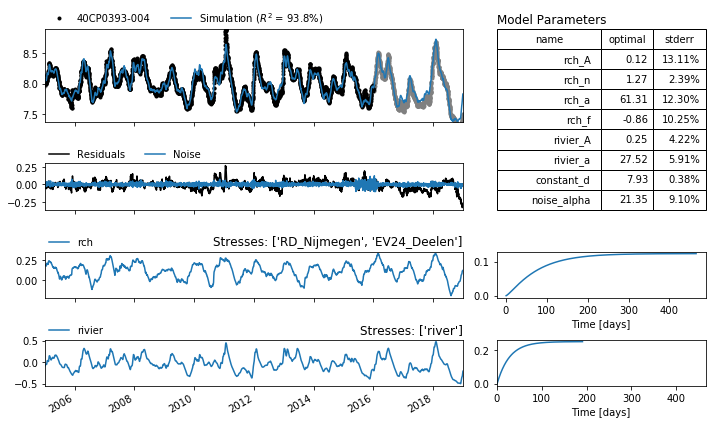

In [14]:
ml.del_stressmodel("rivier")
sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Exponential)
ml.add_stressmodel(sm2)

ml.solve(tmin="2005", tmax="2016", report=False)
ml.plots.results(figsize=(10, 6), tmax="2019");
plt.tight_layout()

Zowel de grondwateraanvulling (of natuurlijk het natuurslagoverschot) als het oppervlaktewaterpeil is in zekere mate afhankelijk van de neerslag. Dit kan er voor zorgen dat de parameters van deze modelonderdelen sterk gecorreleerd zijn en de  bijdragen aan de stijghoogte fluctuaties lastig van elkaar te onderscheiden zijn. Wanneer veranderingen in het oppervlaktewaterpeil net als grondwateraanvulling veroorzaakt wordt door lokale neerslag, kan het zijn dat de bijdragen aan de stijghoogtefluctuaties sterk aan elkaar gecorreleerd zijn. 

In het voorgaande model is dit visueel al zichtbaar, en de correlatie tussen de twee bijdragen is $r=0.60$. Des te sterker de correlatie tussen deze twee bijdragen, des te lastiger zal het zijn een deel van de stijghoogtefluctuatie toe te kennen aan 1 van deze invloeden. Dit kan de mogelijkheid beperken om precieze uitspraken te doen over het effect van een bepaalde invloed op de stijghoogte.

In [15]:
bijdrage_rivier = ml.get_contribution("rivier")
bijdrage_rch = ml.get_contribution("rch")
bijdrage_rch.corr(bijdrage_rivier);

### De invloed van een grondwaterontrekking bepalen
Grondwater wordt door heel Nederland gebruikt voor de productie van drinkwater en als bron van irrigatiewater. Voor het modeleren van stijghoogte tijdreeksen in gebieden waar (in het verleden of nu) grondwater wordt ontrokken is het vaak nodig om een tijdreeks van deze ontrekking mee te nemen. Enige voorbewerking van deze tijdreeksen is over het algemeen nodig, bijvoorbeeld om tijdreeksen met maandelijkse debiet totalen terug te brengen naar een tijdreeks met een gelijke tijdstap (bv. dagsommen). Meer over deze voorbewerking is te vinden in het hoofdstuk over [Voorbewerking](#Voorbewerking).

---
Als voorbeeld kijken we naar een peilbuis in de omgeving van een grondwater pompstation in Vierlingsbeek / Boxmeer. 

HIER MOET EEN BETER VOORBEELD WORDEN GEVONDEN. Dit voorbeeld is lastig, klopt van alles niet. Op zoek naar iets anders.

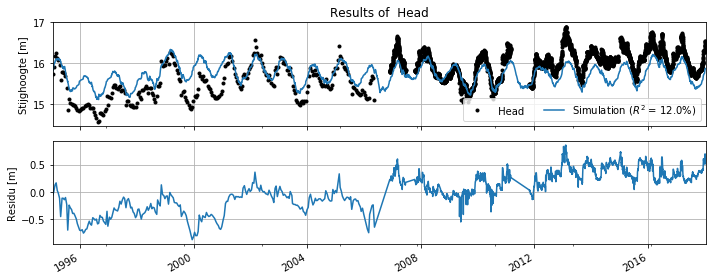

In [16]:
head = pd.read_csv("data/head_wellex.csv", index_col="Date", parse_dates=True, squeeze=True)
rain =  pd.read_csv("data/prec_wellex.csv", index_col="Date", parse_dates=True) * 1e3
evap =  pd.read_csv("data/evap_wellex.csv", index_col="Date", parse_dates=True) * 1e3
well =  pd.read_csv("data/well_wellex.csv", index_col="Date", parse_dates=True) / 1e6

ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, name="recharge",
                      rfunc=ps.Exponential, recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,4), sharex=True)
ml.plot(ax=ax1)
ml.residuals().plot(ax=ax2)
ax1.grid()
ax2.grid()
ax1.set_ylabel("Stijghoogte [m]")
ax2.set_ylabel("Residu [m]")
plt.tight_layout()

#print((ml.stats.pearsonr(weighted=True).round(2)**2).round(2))  # Want ongelijke tijdstappen

In de modelresiduen is een duidelijke trend over de tijd te zien, wat wijst op het mogelijk ontbreken van een invloed. We voegen daarom de tijdreeks van het ontrekkingsdebiet toe aan het model. Deze wordt vertaald naar een bijdrage aan de stijghoogtefluctuaties met behulp van een Gamma response functie. Dit levert het volgende model op.

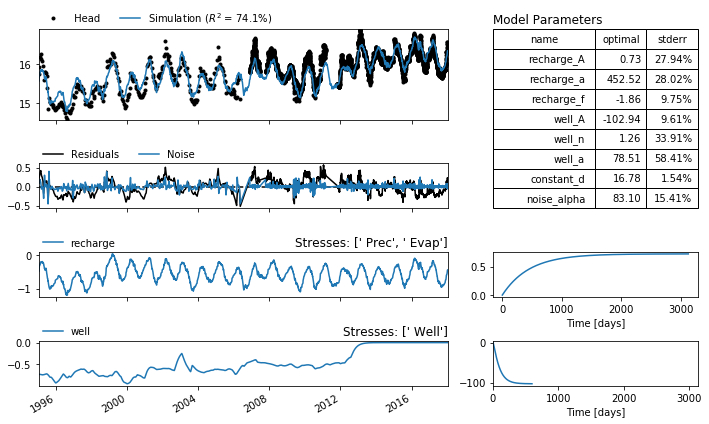

In [17]:
sm = ps.StressModel(well, rfunc=ps.Gamma, name="well", settings="well", up=False)
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False)
ml.plots.results(figsize=(10, 6));

Bovenstaande figuur laat duidelijk zien dat de fit van het model wordt verbeterd door het toevoegen de grondwaterontrekking aan het model. Dit geeft ook de mogelijk om de invloed van het ontrekken van grondwater op de stijghoogte in te schatten. De stap respons kan een indicatie geven van de te verwachten verlaging (verhoging) door het extra (minder) minder ontrekken van een hoeveelheid grondwater. In dit model is gebruik gemaakt van een Gamma respons functie met drie parameters. Een andere respons functie die gebruikt kan worden is bijvoorbeeld de Hantush functie (REFERENTIE?). De volgende figuur geeft het 

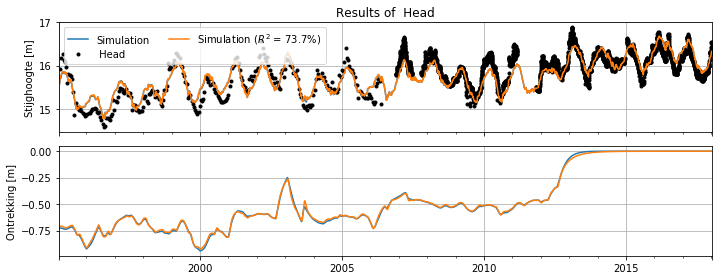

In [18]:
well1 = ml.get_contribution("well")
sim = ml.simulate()

ml.del_stressmodel("well")
sm = ps.StressModel(well, rfunc=ps.Hantush, name="well", settings="well", up=False)
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,4), sharex=True)
sim.plot(ax=ax1)
ml.plot(ax=ax1)

well1.plot(ax=ax2)
ml.get_contribution("well").plot(ax=ax2)

ax1.grid()
ax2.grid()
ax1.set_ylabel("Stijghoogte [m]")
ax2.set_ylabel("Ontrekking [m]")
plt.tight_layout()


Om de invloed van het ontrekken van grondwater op de stijghoogte vast te stellen is het belangrijk dat er enige variatie aanwezig is in de debiet tijdreeks. Er bestaan helaas (nog) geen vuistregel om te bepalen hoeveel variatie in een verklarende tijdreeks genoeg is om de invloed goed te kunnen vast stellen. Of de debietsreeks een periode zonder ontrekken moet bevatten voor het vaststellen van de stijging in de stijghoogtes als gevolg van het stoppen van pompen is bijvoorbeeld onbekend.

### Meerdere grondwaterontrekkingen

Wanneer meerdere pompstations in een gebied aanwezig zijn is het goed mogelijk dat de ruwe debietsreeksen sterk aan elkaar gecorreleerd zijn. Het is dan lastig om de invloed van deze reeksen van elkaar te onderscheiden. In dit geval is het mogelijk om beide reeksen met een enkele responsfunctie te simuleren. De respons functie wordt daarbij geschaald met de afstand van de peilbuis tot de put (REFERENTIE TOEVOEGEN). In het voorbeeld hieronder is dit uitgewerkt.

---

De builbuis XX ligt op 2282 meter afstand van pompput 1 en 2784 meter afstand van pompput 2. Beide ontrekkingen vinden plaats in hetzelfde watervoerende pakket. De responsen van de stijghoogte op beide ontrekkingen zouden dus vergelijkbaar moeten zijn. Bovendien zijn de variaties in de ontrekkingsdebieten in enige mate aan elkaar gecorreleerd ($r=0.65$). In dit geval is het mogelijk om de ontrekkingen te vertalen in stijghoogtefluctuaties met een enkele respons functie die geschaald is met de afstand van de pompput tot de peilbuis. Dit scheelt een aantal parameters, terwijl vaak de fit van het model zeer vergelijkbaar zal zijn. Wanneer met meerdere ontrekkingen wordt gewerkt die water oppompen uitzelfde watervoerende pakket is het dus aan te bevelen een dergelijke model structuur te gebruiken en zo het aantal (te schatten) parameters laag te houden.

In [62]:
head = pd.read_csv("data/mw_head.csv", index_col=0, parse_dates=True, squeeze=True)
prec = pd.read_csv("data/mw_prec.csv", index_col=0, parse_dates=True, squeeze=True)
evap = pd.read_csv("data/mw_evap.csv", index_col=0, parse_dates=True, squeeze=True)
well1 = pd.read_csv("data/mw_well1.csv", index_col=0, parse_dates=True, squeeze=True) / 1e6
well2 = pd.read_csv("data/mw_well2.csv", index_col=0, parse_dates=True, squeeze=True) / 1e6

# fig, [ax1, ax2] = plt.subplots(2,1, figsize=(10,3), sharex=True, sharey=True)
# well1.plot(ax=ax1)
# well2.plot(ax=ax2);
well1.corr(well2);

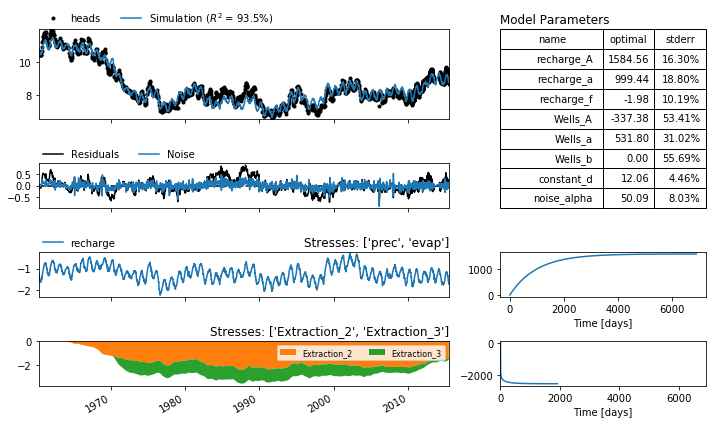

In [63]:
ml = ps.Model(head, name="XXX (filter X)")

sm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Exponential)
distances = [2282, 2784]  #Afstanden van peilbuis tot pomputten
w = ps.WellModel([well1, well2], ps.HantushWellModel, "Wells", distances, settings="well")

ml.add_stressmodel([sm, w])

ml.solve(solver=ps.LmfitSolve, report=False)
ml.plots.stacked_results(figsize=(10, 6));
plt.tight_layout()

## Veranderingen in het systeem

Veranderingen in de stijghoogte fluctuaties dienen niet altijd gemodelleerd te worden met behulp van een verklarende tijdreeks. Er zijn tal van invloeden te bedenken waarbij simpelweg geen tijdreeks van een verandering beschikbaar is, maar wel een kwalitatieve beschrijving van de verandering of het moment van de verandering. Dit kan bijvoorbeeld een peilopzet zijn in een polder waar het oppervlaktewaterpeil niet wordt gemeten, een verandering van het type vegetatie in de loop van de observatie periode, of het langzaam dichtslibben van de rivierbodem waardoor de respons op fluctuaties in het oppervlaktewaterpeil verandert in de tijd. Grofweg drie methoden zijn te onderscheiden om rekening te houden met dit type veranderingen:

- het toevoegen van een lineaire trend over een bepaalde periode
- het toevoegen van een staptrend voor een instantane verandering
- een responsfunctie die door de tijd veranderd.

### Staptrend

Een eenmalige ingreep in de waterhuishouding kan worden gemodelleerd met behulp van een staptrend [(zie bv. von Asmuth et al., 2012)](#Referenties). Een staptrend kan bijvoorbeeld gebruikt worden wanneer een peilverandering is doorgevoert die de stijghoogte beinvloedt. Er kan hierbij worden gekozen voor veen abrupte stijging (wanneer de stijghoogte snel reageert), of een meer geleidelijke stijging (wanneer het grondwatersysteem langzamer reageert. Er kan dus gebruikt worden gemaakt de verschillende responsfuncties die beschrijven hoe de stijghoogte een verandering reageert. Een voorbeeld van een dergelijk model is gegeven voor het 1e filter in peilbuis B51G2150. Hierbij is de staptrend gesimuleerd als een instantaan (de responsfunctie is instantaan zonder vertraging) en de hoogte van de staptrend is een kalibratie parameter.

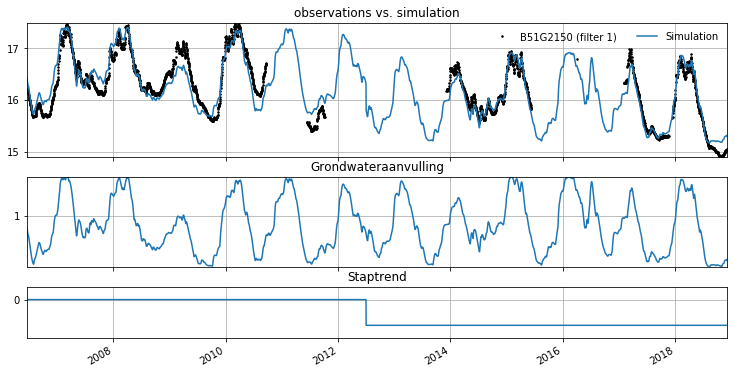

In [55]:
# Voorbeeld van model met stap respons
p = pd.read_csv("data/RD Helmond.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3
e = pd.read_csv("data/EV24 Eindhoven.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3
h = pd.read_csv("data/B51G2150-001.csv", index_col=0, parse_dates=True, squeeze=True)
h.name = "B51G2150 (filter 1)"
# Maak een model
ml = ps.Model(h.iloc[::1])

# Voeg stress modellen toe
sm = ps.RechargeModel(p, e, name="Grondwateraanvulling", rfunc=ps.Exponential, recharge=ps.rch.FlexModel())
step = ps.StepModel(tstart=pd.Timestamp("2012-07-01"), name="Staptrend", up=False)
ml.add_stressmodel([sm, step])

# Kalibreer het model en toon de resultaten
ml.solve(noise=False, report=False)
ml.plots.decomposition(figsize=(10,5), min_ylim_diff=1, split=False);

### Voorbeeld van een model met lineaire trend
Het gebeurt vaak dat een stijghoogte tijdreeks een opwaarste of neerwaartse trend vertoond, die niet door neerslag of verdamping verklaart kan worden. Vaak is het lastig een specifieke oorzaak aan te wijzen van een daling of stijging. Zo kan het bijvoorbeeld goed dat de vegetatietype en daardoor de verdamping en grondwateraanvulling is verandeert in de loop van de tijd. Het zal echter lastig zijn een dergelijk effect te kwantificeren en mee te nemen in het model. Vast staat echter dat zonder de trend mee te nemen in het model het lastig is de stijghoogte goed te modeleren.

---

We beschouwen hier een model voor het 1e filter in de peilbuis "B32C0609" nabij de Bilt. Als eerste stap maken we een model met neerslag en verdamping als verklarende variabelen. Dit levert het volgende model op.

[//]: # (WAT IS HIER DE INVLOED VAN DE HOOGFREQUENTE METINGEN?)

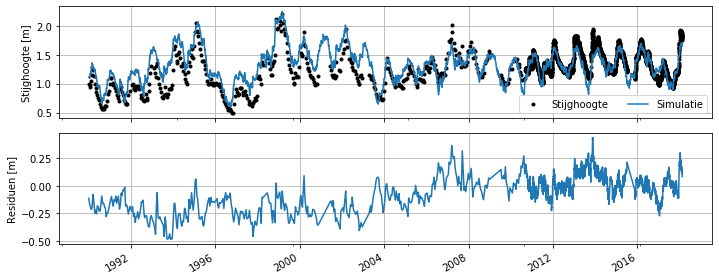

In [59]:
# Loads heads and create Pastas model
head2 = ps.read_dino("data/B32C0609001_1.csv")
evap = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series * 1e3
rain.name = "Neerslag"
evap.name = "Verdamping"

ml2 = ps.Model(head2, name="B32C0609 (filter 1)")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Exponential, name="rch")
ml2.add_stressmodel(rm)

# Solve and plot the model
ml2.solve(noise=False, tmin="1990", report=False)

# Plot het model
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax = ml2.observations().plot(ax=ax1, linestyle=" ", marker=".", color="k");
ml2.simulate().plot(ax=ax1)
ml2.residuals().plot(ax=ax2)
ax1.grid()
ax1.set_ylabel("Stijghoogte [m]")
ax2.grid()
ax2.set_ylabel("Residuen [m]")

ax1.legend(["B32C0609 (filter 1)", "Simulatie", "Residuen"], ncol=3, loc=4)
plt.tight_layout()

In de figuur hierboven is het resultaat van de modellering te weergegeven. We zien dat het model de fluctuaties in de gemeten stijghoogte in het algemeen goed kan verklaren, maar de residuen van het model laten een duidelijke opwaarste trend zien. Het model overschat de stijghoogte in het begin van de kalibratie periode en onderschat de stijghoogte aan het einde van deze periode. 

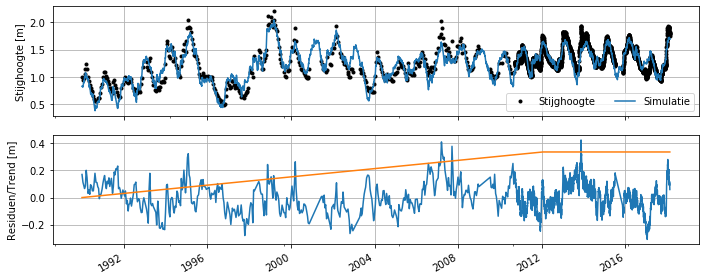

In [60]:
# Add a linear trend
tm = ps.LinearTrend(start="1990", end="2012", name="trend")
ml2.add_stressmodel(tm)

# Solve the model
ml2.solve(noise=False, tmin="1990", initial=False, report=False)

# Plot het model
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax = ml2.observations().plot(ax=ax1, linestyle=" ", marker=".", color="k");
ml2.simulate().plot(ax=ax1)
ml2.residuals().plot(ax=ax2)
ml2.get_contribution("trend").plot(ax=ax2)
ax1.grid()
ax1.set_ylabel("Stijghoogte [m]")
ax2.grid()
ax2.set_ylabel("Residuen/Trend [m]")

ax1.legend(["B32C0609 (filter 1)", "Simulatie", "Residuen", "Trend"], ncol=3, loc=4)
plt.tight_layout()

## Verandering van de responsfunctie in de loop van de tijd
Tot op dit punt in het notebook is verondersteld dat de vorm van de responsfunctie niet verandert in de tijd. Hoewel deze aanname vaak blijkt te werken, zijn er ook situaties waar dit niet het geval is. [Obergfjell et al. (2019)](#Referenties) heeft bijvoorbeeld gekeken naar de situatie waarbij de rivierbodem dichtslibt over de tijd, waardoor de respons van de stijghoogte op fluctuaties in de rivier waterstand verandert in de tijd. Zij hebben daarvoor een model ontwikkeld waarbij de vorm van de respons verandert over de tijd.

## Welke modelstructuur moet ik gebruiken voor de analyse?
Een belangrijke vraag is nu hoe is vast te stellen welke modelstructuur moet worden gebruikt voor de uiteindelijke analyse van het probleem. Deze vraag laat zich lastig eenduidig beantwoorden en is onderdeel van actief onderzoek. In het volgende hoofdstuk over modelbeoordeling wordt uitvoerig op deze vraag ingegaan. Hier behandelen we enkel hoe kan worden vastgesteld of een invloed moet worden meegenomen in het model.

- hoe te bepalen welke invloeden moeten worden meegenomen?
- hoe te bepalen welke modelstructuur beter is?


Welke verklarende variabelen moeten worden meegenomen 

- Toetsen van hydrologische plausibiliteit van evenwichtsrelatie (bv. well_A > 0), diagnostisch toetsen noodzakelijk
- Lengte van de respons functie
- Residuen analyse
- hypothese toetsen

In [25]:
# Voorbeeld van model met pompput en zonder, significante well_A en niet

## Discussie: "everything should be as simple as possible, but not simpler."

In dit notebook is een overzicht gegeven van de verschillende modelstructuren die in Nederland gangbaar zijn. Het is aan te raden meerdere modelstructuren te testen om de stijghoogte te modeleren, voordat een definitief model wordt gekozen. Met name de responsfunctie is makkelijk te varieren en kan een goede manier zijn het aantal parameters te verminderen of de fit te verbeteren. Bovendien is het natuurlijk ook mogelijk meerdere modellen te gebruiken. Een dergelijke multi-model aanpak kan een betere inschatting geven van de modelonzekerheid als gevolg de model structuur [(zie bv. Singh et al., 2010 en Ferré, 2017)](#Referenties). Waar dit voor numerieke grondwatermodellen een significante tijdsinspanning zal opleveren, is het met tijdreeksmodellen relatief makkelijk meerdere modellen te gebruiken.

Hoewel is geprobeerd hier een zo compleet mogelijk overzicht te geven van de mogelijke modelstructuren, moet worden benadrukt dat het relatief makkelijk is nieuwe modelstructuren te ontwikkelen die zijn toegespitst op specifieke situaties. Wanneer bijvoorbeel

Voor specifieke gevallen is het goed mogelijk 

mogelijk zijn en momenteel beschikbaar zijn. 

- Invloed van de meetfrequentie (zie ook bv.  Herwijenen 2001). Welke informatie in een reeks?
- Wat als het sneeuwt
- Verdamping die verandert over de tijd
- Constante die niet constant is (door de tijd)

### onthoud

- schaling tijdreeksen
- normaliseren tijdreeksen
- testen verschillende respons functies
- 


## Referenties

- Knotters M. en de Gooijer, J.G. (1999) TARSO modeling of water table depths. Water Resources Research, 35:3.
- Berendrecht, W., Gehrels, H., van Geer, F., en Heermink, A. (2004) Een niet-lineair tijdreeksmodels voor grondwaterstandsfluctuaties in gedraineerde gebieden. Stromingen 10, nummer 2.
- von Asmuth et al. (2002)
- Berendrecht et al. (2006)
- Von Asmuth, J. R., Maas, K., Knotters, M., Bierkens, M. F., Bakker, M., Olsthoorn, T. N., Cirkel, D.G., Leunk, I., & Von Asmuth, D. C. (2012). Software for hydrogeologic time series analysis, interfacing data with physical insight. Environmental Modelling & Software, 38, 178-190.
- von Asmuth, J.,van der Schaaf, S., Grootjans, A., en Maas, K. (2012) Vennen en veentjes: (niet-)ideale systemen voor niet-lineaire tijdreeksmodellen, Stromingen 18, Nummer 2.
- Peterson and Western (2014)
- Collenteur et al. (2020)
- Ferré, T.P. (2017), Revisiting the Relationship Between Data, Models, and Decision‐Making. Groundwater, 55: 604-614. https://doi.org/10.1111/gwat.12574
- Singh, A., Mishra, S. and Ruskauff, G. (2010), Model Averaging Techniques for Quantifying Conceptual Model Uncertainty. Groundwater, 48: 701-715. https://doi.org/10.1111/j.1745-6584.2009.00642.x

## Beschikbaarheid van opties
In de volgende tabel wordt een overzicht gegeven welke opties in verschillende software pakketten beschikbaar zijn. **Dit overzicht komt niet in dit Notebook**

|Optie|Pastas|Menyanthes|Hydrosight|
|--|--|--|--|
|Drempel niet-lineariteit|Ja|Ja|Nee|
|niet-lineaire grondwateraanvulling|Ja|Nee|Ja|
|Stap respons|Ja|Ja|Onbekend|
|Lineaire trend|Ja|Ja|Onbekend|
|Veranderende respons|Nee|Nee|Nee|